# MAP / SSP / TL plot

In [1]:
import xarray as xr
import envy
from kaooi.coordinates import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cmocean
from dask.distributed import Client
import matplotlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors as mcolors
from matplotlib.patches import Rectangle
import os
from dotenv import load_dotenv
import fsspec

# load .env file
env_path = '../.env'
_ = load_dotenv(env_path)

%config InlineBackend.figure_format = 'retina'

/gscratch/coenv/jhrag/miniconda/envs/kb/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


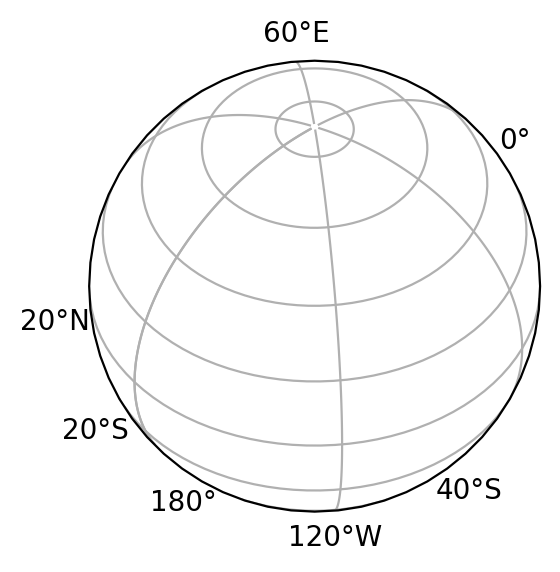

In [8]:
fig = plt.figure()
gs = gridspec.GridSpec(2,2)

ax_map = fig.add_subplot(
    gs[:,0],
    projection=ccrs.Orthographic(
        central_longitude=-127,
        central_latitude=45
    )
)

ax_map.gridlines(draw_labels=True)

In [9]:
bathy_full = xr.open_dataset(os.environ['global_bathymetry'])

In [10]:
ssp = envy.get_ssp_slice(coords['KB'], coords['LJ01C'], 1100, fillna=True)
bathy = envy.get_bathymetry_slice(coords['KB'], coords['LJ01C'], 1100)

In [11]:
fs = fsspec.filesystem('')
fns = fs.glob(f'{os.environ["data_directory"]}tl_iws/*.nc')

tl = xr.open_mfdataset(fns, combine='nested', concat_dim='realizations')['__xarray_dataarray_variable__']

In [12]:
tl_mean = (20*np.log10(np.abs(tl)[:,0,:,:].mean('realizations'))).compute()

In [ ]:
lat_bounds = (42, 48)
lon_bounds = (-131, -122)

lf_nodes = ['AXBA1','AXCC1','AXEC2','HYS14','HYSB1']
lf_coords = {k:coords[k] for k in coords.keys() if k in lf_nodes}

bb_nodes = ['PC01A','PC03A','LJ01D','LJ01C']
bb_coords = {k:coords[k] for k in coords.keys() if k in bb_nodes}

plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(6.67, 3.2))

gs = gridspec.GridSpec(2,2)

ax_map = fig.add_subplot(
    gs[:,0],
    projection=ccrs.Orthographic(
        central_longitude=-127,
        central_latitude=45
    )
)
ax_ssp = fig.add_subplot(gs[0,1])
ax_tl = fig.add_subplot(gs[1,1])

axes = [ax_map, ax_ssp, ax_tl]

# add letters
letters=['(a)','(b)','(c)']
for k, ax in enumerate(axes):
    if k == 0:
        text_pos = [0.05, 0.95]
    else:
        text_pos = [0.05, 0.9]
    ax.text(
        text_pos[0],
        text_pos[1],
        letters[k],
        transform=ax.transAxes,
        fontsize=8,
        zorder=100,
        bbox=dict(facecolor='white', edgecolor='k', pad=0.3, linewidth=0.5))


## Sound Speed
plt.sca(ax_ssp)

ssp.plot(x = 'range', y='depth', vmax=1570, cmap='mako', cbar_kwargs={'label':'sound speed [m/s]'}, rasterized=True)
plt.fill_between(bathy.range, 10000, bathy.values, lw=0.25, color='#aaaaaa', edgecolor='k', zorder=10)
ssp.plot.contour(x = 'range', y = 'depth', levels = np.arange(1460,1550,3), colors='w', linewidths=0.5, alpha=0.25)
plt.scatter([0], [depths['KB']], zorder=15, facecolor='#00aa00', edgecolor='k', lw=0.5, s=35, clip_on=False, marker='v')
plt.scatter([bathy.range[-1]], [depths['LJ01C']], zorder=15, facecolor='#ff5555', edgecolor='k', lw=0.5, s=35, clip_on=False, marker='^')

plt.xlim([0,bathy.range[-1]])
plt.ylim([6000,0])
plt.xlabel('range [km]', labelpad=0)
plt.ylabel('depth [m]')


plt.sca(ax_tl)
(-1*tl_mean).plot(x='range', vmax=135, vmin=95, cmap='rocket_r', cbar_kwargs={'label':'transmission loss [dB]'}, rasterized=True)
plt.fill_between(bathy.range, 10000, bathy.values, lw=0.25, color='#aaaaaa', edgecolor='k', zorder=10)
plt.ylim([6000,0])
plt.title('')

plt.xlabel('range [km]', labelpad=0)
plt.ylabel('depth [m]')
plt.ylim([6000,0])
plt.scatter([0], [depths['KB']], zorder=15, facecolor='#00aa00', edgecolor='k', lw=0.5, s=35, clip_on=False, marker='v')
plt.scatter([bathy.range[-1]], [depths['LJ01C']], zorder=15, facecolor='#ff5555', edgecolor='k', lw=0.5, s=35, clip_on=False, marker='^')

plt.tight_layout(pad=0.15)


# plot map
plt.sca(ax_map)
bathy_full['elevation'].sel(
    {
        'lon':slice(lon_bounds[0]-1, lon_bounds[1]+1), 'lat':slice(lat_bounds[0]-1, lat_bounds[1]+1)
    }).plot(
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.topo,
    vmin=-6000,
    vmax=6000,
    add_colorbar=False,
    rasterized=True
)

ax_map.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
lats = []
lons = []

for node in bb_coords:
    lats.append(coords[node][0])
    lons.append(coords[node][1])

for node in lf_nodes + bb_nodes:
    plt.plot(
        [coords['KB'][1], coords[node][1]],
        [coords['KB'][0], coords[node][0]],
        transform=ccrs.PlateCarree(),
        lw=2,
        c='w',
        alpha=0.5
    )

plt.scatter(
    x=lons,
    y=lats,
    transform=ccrs.PlateCarree(),
    marker='^',
    lw=0,
    c='r',
    label='fs=64kHz',
    zorder=10
)

lats = []
lons = []

for node in lf_coords:
    lats.append(coords[node][0])
    lons.append(coords[node][1])
    
plt.scatter(
    x=lons,
    y=lats,
    transform=ccrs.PlateCarree(),
    lw=0.5,
    facecolor='blue',
    alpha=0.5,
    s=15,
    edgecolor='k',
    label='fs=200Hz',
    zorder=10
)

leg = plt.legend(loc='lower right')
leg.get_frame().set_facecolor((1, 1, 1, 1))

# Add latitude and longitude grid lines
gl = ax_map.gridlines(draw_labels=True, linewidth=0.75, color='#dddddd', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add elevation colorbar
el_cbar_background = fig.add_axes((0.15, 0.75, 0.28, 0.18))
el_cbar = fig.add_axes((0.17, 0.9, 0.25, 0.02))

# Remove x and y spines
el_cbar_background.spines['left'].set_visible(False)
el_cbar_background.spines['right'].set_visible(False)
el_cbar_background.spines['top'].set_visible(False)
el_cbar_background.spines['bottom'].set_visible(False)

# Remove ticks
el_cbar_background.set_xticks([])
el_cbar_background.set_yticks([])

# Set face color with alpha=0.5
el_cbar_background.set_facecolor((1, 1, 1, 0.5))  # White with 0.5 alpha

# add colorbar axes
cb_el = matplotlib.colorbar.ColorbarBase(
    el_cbar,
    cmap=cmocean.cm.topo,
    norm=mcolors.Normalize(vmin=-6000, vmax=6000),
    orientation='horizontal',
    label='elevation [m]'
)


# Add inset
ax_inset = fig.add_axes(
    (0.001, 0.14, 0.15, 0.25),
    projection=ccrs.Orthographic(
        central_latitude = 30,
        central_longitude = -140
    )
)

ax_inset.set_yticks([])
ax_inset.set_xticks([])
plt.sca(ax_inset)

bathy_full['elevation'].plot(transform=ccrs.PlateCarree(),cmap=cmocean.cm.topo,vmin=-6000,vmax=6000,add_colorbar=False,rasterized=True)
plt.scatter(coords['KB'][1], coords['KB'][0], transform=ccrs.PlateCarree(), zorder=10, lw=0.5, facecolor='green', alpha=0.75, s=25,edgecolor='k', marker='v')
ax_inset.spines['geo'].set_visible(False)

for node in hydrophones:
    if node in ['AXCC1', 'LJ01C']:
        plt.scatter(coords[node][1], coords[node][0], transform=ccrs.PlateCarree(), zorder=10, lw=0.5, facecolor='blue', alpha=0.75, s=25 ,edgecolor='k')
        ax_inset.plot([coords['KB'][1], coords[node][1]], [coords['KB'][0], coords[node][0]], transform=ccrs.PlateCarree(), c='w', alpha=0.5)


plt.xlabel('')
plt.ylabel('')
ax_inset.spines[['right', 'left','top','bottom']].set_visible(False)


fig.savefig('figures/environment.pdf', dpi=500)
fig.savefig('figures/environment.png', dpi=500)
plt.close()